In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# <center>Keras Sequential Model Quickstart 🚀 </center>
In this notebook, we'll go through Keras Sequential Model API so you can easily get started with Tensorflow. 

# Table of content 

<a id="toc"></a>
[1. Loading and preprocessing data (reshape and scaling)](#1)<br>
[2. Build a simple Sequential model and understand the math behind it](#2)<br>
[3. Define a loss function, compile and fit our model.](#3)<br>
[4. Prediction and submission](#4)<br>
 


## <center> Hope you'll like it and don't forget to upvote if you find it useful 👍 </center>

<a id="1"></a>
# **<center><span style="color:#FF7B5F;">1. Loading and preprocessing data (reshape and scaling)</span></center>**
Let's first start by loading the data using pandas.

In [ ]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [ ]:
print('train shape: ', train.shape)
print('test shape: ', test.shape)
train.head()

In [ ]:
x_train, x_test, y_train = train.drop('label', axis =1), test.copy(), train['label']
sns.countplot(x=y_train)

Now let's see what is the range of values for x so we can normalize its values.

In [ ]:
x_train.max().max()

Here we'll reshape the image to a 28x28 pixel (which makes more sense than a 1x784 for an image)

In [ ]:
x_train, x_test = x_train.values.reshape(-1,28,28,1)/255, x_test.values.reshape(-1,28,28,1)/255

In [ ]:
plt.imshow(x_train[123][:,:,0], cmap='gray_r')

28x28 is better that 1x784 for visualization isn't it? 

<a id="2"></a>
# **<center><span style="color:#FF7B5F;">2. Build a simple Sequential model and understand the math behind it</span></center>**


We define a few layers: 
- the first one takes input of 28x28 
- the last one gives an output of size 10
- in the middle you can add other layers, don't forget to add a dropout layer to avoid overfitting on the training data.

In [ ]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, kernel_size =3, activation='relu', input_shape=(28,28,1))
    self.conv2 = Conv2D(32, 3, activation='relu')
    self.maxpool1 = MaxPool2D(pool_size=(2,2))
    self.do1 = Dropout(0.25)
    
    self.conv3 = Conv2D(64, 3, activation='relu')
    self.conv4 = Conv2D(64, 3, activation='relu')
    self.maxpool2 = MaxPool2D(pool_size=(2,2))
    self.do2 = Dropout(0.25)
    
    self.flatten = Flatten()
    self.d1 = Dense(256, activation='relu')
    self.do3 = Dropout(0.4)
    self.d2 = Dense(10, activation='softmax')

    
  def call(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.maxpool1(x)
    x = self.do1(x)
    
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.maxpool2(x)
    x = self.do2(x)
    
    x = self.flatten(x)
    x = self.d1(x)
    x = self.do3(x)
    
    return self.d2(x)

# Create an instance of the model
model = MyModel()

In [ ]:
predictions = model(x_train[:1]).numpy()
predictions

Let's talk a little bit about math here. 2 things are interesting to mention here. 
- the predictions are not probabilities, they are logits (or the inverse of the sigmoid function drawed below)
- if we want to convert those numbers to probabilities, we can use the softmax function that is desrbied below. 
    - the intuition behind softmax is to use exponentials to make all numbers positive and then weigh them

In [ ]:
x = np.linspace(-10,10,1000)
y = tf.nn.sigmoid(x, name ='sigmoid')
plt.plot(x, y)
plt.title("Sigmoid Function")

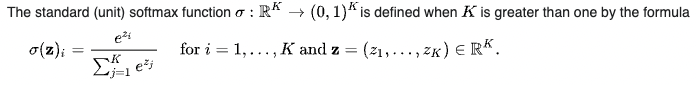

In [ ]:
tf.nn.softmax(predictions).numpy()
#note that these should sum up to 1 based on softmax definition ;) 

<a id="3"></a>
# **<center><span style="color:#FF7B5F;">3. Define a loss function & optimizer, compile and fit our model. </span></center>**


In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

Note that we haven't trained our model thus far. So it should guess with a probability 1/10 

➡ so the initial loss should be close to -log(1/10) ≈ 2.3.

In [ ]:
np.mean([loss_fn(y_train[x:x+1], predictions).numpy() for x in range(100)])

Now let's compile our model with the defined loss function and train it.

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=5)

<a id="4"></a>
# **<center><span style="color:#FF7B5F;">4. Prediction and submission </span></center>**


Remember that our model outputs logits so we need to add a softmax layer to convert them to probabilities if this is what you are looking for. 

In [ ]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [ ]:
probability_model(x_test[:5])

If you don't care about probabilities, you can also just use the logits and take the highest one (using argmax function) to get the preiction. Note that softmax does not change the relative order of values but just outputs everything as probabilities.

In [ ]:
predictions = model.predict(x_test)
y_test = np.argmax(predictions,axis = 1)

For the submission format we need to have a dataframe with 2 columns (ImageId and Label)

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),pd.Series(y_test, name ='Label')],axis = 1)
submission.to_csv('submission.csv', index=False)

__I hope you found this notebook. If you liked it or learned something new, do not hesitate to upvote it :)__